In [1]:
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from sklearn.cluster import KMeans
import folium
import requests
import geocoder

## OBTAINING SINGAPORE DISTRICT NAMES

In [2]:
url = 'https://en.wikipedia.org/wiki/Postal_codes_in_Singapore'
html_data = requests.get(url).text
sg = BeautifulSoup(html_data, 'html5lib')

In [3]:
singapore = pd.DataFrame(columns = ['District'])
for row in sg.find('tbody').find_all('tr'):
    
    col = row.find_all('td')
    if len(col) == 0:
        continue
    
    dis = col[2].text.strip('\n')
    
    singapore = singapore.append({'District' : dis}, ignore_index = True)

singapore

,District
0,"Raffles Place, Cecil, Marina, People's Park"
1,"Anson, Tanjong Pagar"
2,"Bukit Merah, Queenstown, Tiong Bahru"
3,"Telok Blangah, Harbourfront"
4,"Pasir Panjang, Hong Leong Garden, Clementi New..."
5,"High Street, Beach Road (part)"
6,"Middle Road, Golden Mile"
7,"Little India, Farrer Park, Jalan Besar, Lavender"
8,"Orchard, Cairnhill, River Valley"
9,"Ardmore, Bukit Timah, Holland Road, Tanglin"


## GETTING LATITUDE AND LONGITUDES FOR THE DISTRICTS

In [4]:
lat = []
long = []

for dis in singapore['District']:
    
    coords = None
    while(coords is None):
        g = geocoder.arcgis('{}, Singapore'.format(dis))
        coords = g.latlng
    
    lat.append(coords[0])
    long.append(coords[1])

In [5]:
singapore['Latitude'] = lat
singapore['Longitude'] = long
singapore

,District,Latitude,Longitude
0,"Raffles Place, Cecil, Marina, People's Park",1.281890,103.849120
1,"Anson, Tanjong Pagar",1.278890,103.845390
2,"Bukit Merah, Queenstown, Tiong Bahru",1.293048,103.806248
3,"Telok Blangah, Harbourfront",1.265331,103.818861
4,"Pasir Panjang, Hong Leong Garden, Clementi New...",1.314730,103.756799
5,"High Street, Beach Road (part)",1.290619,103.849451
6,"Middle Road, Golden Mile",1.299462,103.852847
7,"Little India, Farrer Park, Jalan Besar, Lavender",1.307100,103.858420
8,"Orchard, Cairnhill, River Valley",1.306540,103.839410
9,"Ardmore, Bukit Timah, Holland Road, Tanglin",1.323305,103.784985


### PLOTTING ON MAP

In [6]:
sg_coords = [1.290270, 103.851959]
map_sg = folium.Map(location = sg_coords)

In [7]:
for lat, lng, district in zip(singapore['Latitude'], singapore['Longitude'], singapore['District']):
    
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_sg)
    
map_sg

## TOP HOTELS IN SINGAPORE USING FOURSQUARE API

In [8]:
hotels = pd.read_csv('hotels.csv')
hotels

,Latitude,Longitude
0,1.311786,103.879565
1,1.311956,103.881122
2,1.309430,103.858162
3,1.285005,103.834727
4,1.300614,103.842228
...,...,...
420,1.315688,103.897421
421,1.311068,103.862164
422,1.321240,103.853270
423,1.323345,103.852504


In [9]:
for lat, lng in zip(hotels['Latitude'], hotels['Longitude']):
    
    folium.RegularPolygonMarker(
        [lat, lng],
        radius=4,
        color='blue',
        #fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        #parse_html=False
    ).add_to(map_sg)

In [10]:
map_sg

CLEARLY, MOST BIG HOTEL CHAINS IN THE SOUTH OF SINGAPORE. LET US TRY AND ANALYSE WHY.

## ANALYSING BEST TOURIST ATTRACTIONS

In [11]:
url_tourist = 'https://www.thrillophilia.com/places-to-visit-in-singapore'
tour_data = requests.get(url_tourist).text

In [12]:
tour = BeautifulSoup(tour_data, 'html5lib')

In [13]:
attractions = []
for dest in tour.find_all('h3', class_ = 'h3 title'):
    attractions.append(dest.text.strip())

In [14]:
attr_lat = []
attr_long = []
for loc in attractions:
    coords = None
    while(coords is None):
        g = geocoder.arcgis('{}, Singapore'.format(loc))
        coords = g.latlng
    
    attr_lat.append(coords[0])
    attr_long.append(coords[1])
    
    folium.features.CircleMarker(
        [coords[0], coords[1]],
        radius=3,
        color='yellow',
        popup=loc,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(map_sg)

In [15]:
map_sg

<b> Most of the famous tourist attractions are located towards the South, thus it makes sense that there is a large cluster of hotels around the attractions.
</b>

## EXPLORING THE DISTRICTS USING FOURSQAURE API

In [18]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version
LIMIT = 100
radius = 2000

In [19]:
venues = []

for lat, long, dis in zip(singapore['Latitude'], singapore['Longitude'], singapore['District']):
    
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            dis,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [20]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['District', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
venues_df.head()

,District,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Napoleon Food & Wine Bar,1.279925,103.847333,Wine Bar
1,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Luke's Oyster Bar & Chop House,1.282459,103.847240,Seafood Restaurant
2,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Grain Traders,1.281468,103.850039,Restaurant
3,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Amoy Hotel,1.283118,103.848539,Hotel
4,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Freehouse,1.281254,103.848513,Beer Garden


## FINDING LESS DEVELOPED NEIGHBOURHOODS

<AxesSubplot:ylabel='District'>

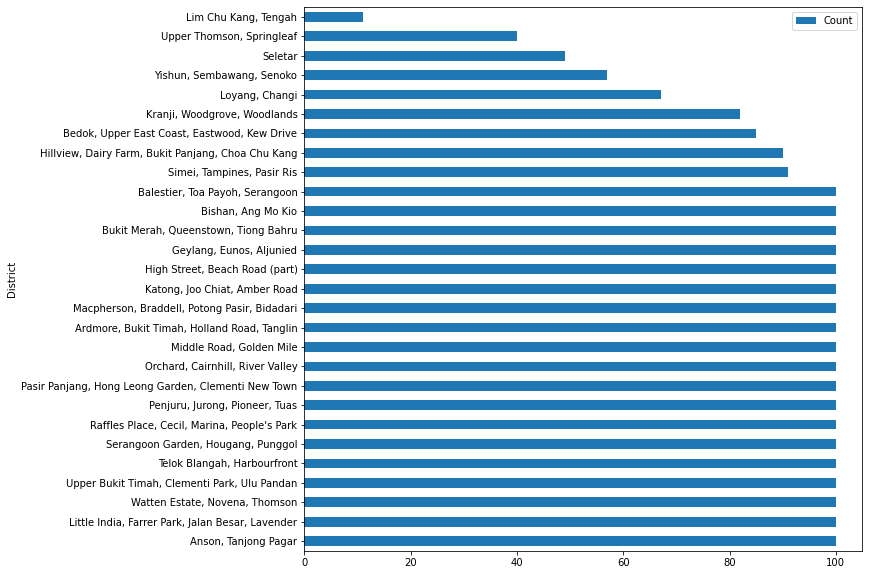

In [21]:
a = venues_df.groupby('District').count()['VenueCategory'].to_frame()
a = a.sort_values(['VenueCategory'], ascending = False)
a.columns = ['Count']
a.plot(kind = 'barh', figsize = (10, 10))

## ANALYSING THE DIFFERENT VENUES

In [22]:
temp = venues_df.groupby('VenueCategory').count()['District']

<AxesSubplot:ylabel='VenueCategory'>

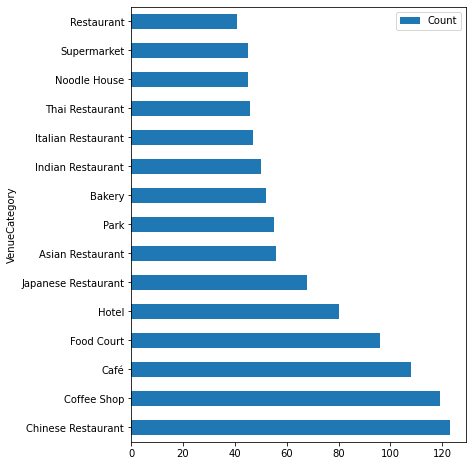

In [23]:
values = temp.to_frame()
venue_top15 = values.sort_values(['District'], ascending = False).head(15)
venue_top15.columns = ['Count']
venue_top15.plot(kind = 'barh', figsize = (6, 8))

## FINDING 10  MOST COMMON VENUES PER DISTRICT

In [24]:
onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")
onehot.insert(0, 'District', venues_df['District'])

In [25]:
grouped_nh = onehot.groupby('District').mean().reset_index()
grouped_nh.head()

,District,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Anson, Tanjong Pagar",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.020000,0.00,0.0,0.02
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.0,0.0,0.0,0.0,0.010000,0.00,0.0,0.00
2,"Balestier, Toa Payoh, Serangoon",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.0,0.0,0.0,0.0,0.010000,0.01,0.0,0.00
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.011765,0.00,0.0,0.00
4,"Bishan, Ang Mo Kio",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00


In [26]:
most_common = pd.DataFrame(columns = ['District'] + [str(i) for i in range(1, 11)])

In [27]:
for j, nh in enumerate(grouped_nh['District']):
    
    l = []
    for i, col in enumerate(grouped_nh.columns.to_list()):
        if(i == 0):
            continue

        l.append((col, grouped_nh.iloc[j, i]))
        
    a = sorted(l, key = lambda x:x[1], reverse = True)[:10]
    names = [x for (x, y) in a]
    values = {}
    values["District"] = nh
    for k in range(1, 11):
        values[str(k)] = names[k - 1]
    most_common = most_common.append(values, ignore_index = True)

In [28]:
most_common

,District,1,2,3,4,5,6,7,8,9,10
0,"Anson, Tanjong Pagar",Hotel,Coffee Shop,Korean Restaurant,Bar,Cocktail Bar,Restaurant,Spanish Restaurant,Gym / Fitness Center,Japanese Restaurant,Ramen Restaurant
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",Bakery,Japanese Restaurant,Supermarket,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Bar,Café,Chinese Restaurant,Coffee Shop
2,"Balestier, Toa Payoh, Serangoon",Chinese Restaurant,Coffee Shop,Noodle House,Café,Asian Restaurant,Bakery,Dessert Shop,Ice Cream Shop,Food Court,Italian Restaurant
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",Food Court,Noodle House,Chinese Restaurant,Coffee Shop,Beach,Asian Restaurant,Café,Seafood Restaurant,Dessert Shop,Pier
4,"Bishan, Ang Mo Kio",Chinese Restaurant,Café,Food Court,Coffee Shop,Park,Thai Restaurant,Asian Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House
5,"Bukit Merah, Queenstown, Tiong Bahru",Chinese Restaurant,Café,Park,Coffee Shop,Food Court,Indian Restaurant,Seafood Restaurant,Asian Restaurant,Bakery,French Restaurant
6,"Geylang, Eunos, Aljunied",Chinese Restaurant,Food Court,BBQ Joint,Café,Dim Sum Restaurant,Seafood Restaurant,Italian Restaurant,Noodle House,Stadium,Vegetarian / Vegan Restaurant
7,"High Street, Beach Road (part)",Hotel,Japanese Restaurant,Restaurant,Cocktail Bar,Event Space,Wine Bar,Art Gallery,Buffet,Café,Coffee Shop
8,"Hillview, Dairy Farm, Bukit Panjang, Choa Chu ...",Trail,Coffee Shop,Fast Food Restaurant,Shopping Mall,Supermarket,Café,Food Court,Italian Restaurant,Park,Rest Area
9,"Katong, Joo Chiat, Amber Road",Chinese Restaurant,Bar,Coffee Shop,Food Court,Hotel,Italian Restaurant,Japanese Restaurant,Noodle House,Asian Restaurant,Bakery


## CLUSTERING THE DISTRICTS

In [29]:
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters, n_init = 12)
X = grouped_nh.drop(['District'], axis = 1)
kmeans.fit(X)

KMeans(n_clusters=4, n_init=12)

In [30]:
most_common.insert(0, 'Cluster Label', kmeans.labels_)
most_common.head()

,Cluster Label,District,1,2,3,4,5,6,7,8,9,10
0,2,"Anson, Tanjong Pagar",Hotel,Coffee Shop,Korean Restaurant,Bar,Cocktail Bar,Restaurant,Spanish Restaurant,Gym / Fitness Center,Japanese Restaurant,Ramen Restaurant
1,3,"Ardmore, Bukit Timah, Holland Road, Tanglin",Bakery,Japanese Restaurant,Supermarket,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Bar,Café,Chinese Restaurant,Coffee Shop
2,3,"Balestier, Toa Payoh, Serangoon",Chinese Restaurant,Coffee Shop,Noodle House,Café,Asian Restaurant,Bakery,Dessert Shop,Ice Cream Shop,Food Court,Italian Restaurant
3,3,"Bedok, Upper East Coast, Eastwood, Kew Drive",Food Court,Noodle House,Chinese Restaurant,Coffee Shop,Beach,Asian Restaurant,Café,Seafood Restaurant,Dessert Shop,Pier
4,3,"Bishan, Ang Mo Kio",Chinese Restaurant,Café,Food Court,Coffee Shop,Park,Thai Restaurant,Asian Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House


In [31]:
lat = []
long = []

for nh in most_common['District']:
    
    temp = venues_df[venues_df['District'] == nh].reset_index()
    lat.append(temp.loc[0, 'VenueLatitude'])
    long.append(temp.loc[0, 'VenueLongitude'])
    

most_common.insert(2, 'Latitude', lat)
most_common.insert(3, 'Longitude', long)

### VISUALIZING THE CLUSTERS

In [32]:
map_clusters = folium.Map(location=sg_coords, zoom_start=11)

x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []

for lat, lon, poi, cluster in zip(most_common['Latitude'], most_common['Longitude'], most_common['District'], most_common['Cluster Label']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

   ### VISUALIZING THE TOURIST ATTRACTIONS WITH RESPECT TO THE CLUSTERS

In [33]:
for i, loc in enumerate(attractions):
    lat = attr_lat[i]
    long = attr_long[i]
    folium.features.CircleMarker(
        [lat, long],
        radius=3,
        color='yellow',
        popup=loc,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(map_clusters)

In [34]:
map_clusters

## ANALYSING THE CLUSTERS

### 1

In [37]:
most_common.loc[most_common['Cluster Label'] == 3, most_common.columns[[1] + list(range(5, most_common.shape[1]))]]

,District,2,3,4,5,6,7,8,9,10
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",Japanese Restaurant,Supermarket,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Bar,Café,Chinese Restaurant,Coffee Shop
2,"Balestier, Toa Payoh, Serangoon",Coffee Shop,Noodle House,Café,Asian Restaurant,Bakery,Dessert Shop,Ice Cream Shop,Food Court,Italian Restaurant
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",Noodle House,Chinese Restaurant,Coffee Shop,Beach,Asian Restaurant,Café,Seafood Restaurant,Dessert Shop,Pier
4,"Bishan, Ang Mo Kio",Café,Food Court,Coffee Shop,Park,Thai Restaurant,Asian Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House
5,"Bukit Merah, Queenstown, Tiong Bahru",Café,Park,Coffee Shop,Food Court,Indian Restaurant,Seafood Restaurant,Asian Restaurant,Bakery,French Restaurant
6,"Geylang, Eunos, Aljunied",Food Court,BBQ Joint,Café,Dim Sum Restaurant,Seafood Restaurant,Italian Restaurant,Noodle House,Stadium,Vegetarian / Vegan Restaurant
9,"Katong, Joo Chiat, Amber Road",Bar,Coffee Shop,Food Court,Hotel,Italian Restaurant,Japanese Restaurant,Noodle House,Asian Restaurant,Bakery
17,"Pasir Panjang, Hong Leong Garden, Clementi New...",Bakery,Café,Chinese Restaurant,Coffee Shop,Food Court,Asian Restaurant,Fried Chicken Joint,Japanese Restaurant,Noodle House
18,"Penjuru, Jurong, Pioneer, Tuas",Café,Chinese Restaurant,Food Court,Japanese Restaurant,Indian Restaurant,Shopping Mall,Bubble Tea Shop,Clothing Store,Italian Restaurant
20,Seletar,Asian Restaurant,Café,Coffee Shop,Indian Restaurant,Restaurant,Airport Service,Airport Terminal,Bar,Beer Garden


<b> THIS IS THE CLUSTER WHICH COVERS A PRETTY LARGE AREA OF SINGAPORE. IT INCLUDES 15 DISTRICTS. WE CAN SEE THAT THE MOST COMMON VENUES IN THESE DISTRICTS INCLUDE RESTAURANTS AND CAFE'S OF DIFFERENT KINDS, COVERING MANY CUISINES. THUS, IT IS NOT VERY ECONOMICAL TO OPEN ANY RESTAURANTS IN THESE DISTRICTS </b>
<hr>

### 2

In [38]:
most_common.loc[most_common['Cluster Label'] == 2, most_common.columns[[1] + list(range(5, most_common.shape[1]))]]

,District,2,3,4,5,6,7,8,9,10
0,"Anson, Tanjong Pagar",Coffee Shop,Korean Restaurant,Bar,Cocktail Bar,Restaurant,Spanish Restaurant,Gym / Fitness Center,Japanese Restaurant,Ramen Restaurant
7,"High Street, Beach Road (part)",Japanese Restaurant,Restaurant,Cocktail Bar,Event Space,Wine Bar,Art Gallery,Buffet,Café,Coffee Shop
12,"Little India, Farrer Park, Jalan Besar, Lavender",Hotel,Café,Chinese Restaurant,Coffee Shop,Thai Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Ice Cream Shop,Italian Restaurant
14,"Macpherson, Braddell, Potong Pasir, Bidadari",Event Space,Waterfront,Café,Cocktail Bar,Japanese Restaurant,Restaurant,Shopping Mall,Buffet,Coffee Shop
15,"Middle Road, Golden Mile",Café,Japanese Restaurant,Cocktail Bar,Coffee Shop,Event Space,Restaurant,Art Gallery,Arts & Crafts Store,Bakery
16,"Orchard, Cairnhill, River Valley",Shopping Mall,Bakery,Chinese Restaurant,Japanese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Hotpot Restaurant,Indonesian Restaurant
19,"Raffles Place, Cecil, Marina, People's Park",Bar,Restaurant,Cocktail Bar,Coffee Shop,Japanese Restaurant,Seafood Restaurant,Spanish Restaurant,Waterfront,Yoga Studio
23,"Telok Blangah, Harbourfront",Theme Park,Beach,Scenic Lookout,Café,Chinese Restaurant,Pool,Resort,Trail,Candy Store


<b> THIS IS THE CLUSTER LOCATED RIGHT AMONGST THE TOURIST ATTRACTIONS. THIS IS THE AREA WHICH CONTAINS MOST BIG HOTEL CHAINS AND APART FROM RESTAURANTS, ALSO HAS OTHER ATTRACTIONS LIKE ART GALLERIES. THIS AREA IS ALREADY VERY DEVELOPED AND CLEARLY, HAS THE HIGHEST FOOT TRAFFIC IN SINGAPORE. </b>
<hr>

### 3

In [36]:
most_common.loc[most_common['Cluster Label'] == 1, most_common.columns[[1] + list(range(5, most_common.shape[1]))]]

,District,2,3,4,5,6,7,8,9,10
11,"Lim Chu Kang, Tengah",Asian Restaurant,Beer Bar,Campground,Clothing Store,Other Great Outdoors,Theme Park Ride / Attraction,Vegetarian / Vegan Restaurant,Accessories Store,Airport


<b> THIS CLUSTER, ONLY INCLUDES ONE DISTRICT, LOCATED FAR NORTH WEST. IT IS AWAY FROM MOST TOURIST ATTRACTIONS AND IS MAINLY SUBURBAN. IT IS NOT VERY SUITABLE FOR NEW PROJECTS, AS THERE IS VERY LITTLE DEVELOPEMENT </b>

<hr>

### 4

In [35]:
most_common.loc[most_common['Cluster Label'] == 0, most_common.columns[[1] + list(range(5, most_common.shape[1]))]]

,District,2,3,4,5,6,7,8,9,10
8,"Hillview, Dairy Farm, Bukit Panjang, Choa Chu ...",Coffee Shop,Fast Food Restaurant,Shopping Mall,Supermarket,Café,Food Court,Italian Restaurant,Park,Rest Area
10,"Kranji, Woodgrove, Woodlands",Fast Food Restaurant,Café,Coffee Shop,Park,Shopping Mall,Trail,Asian Restaurant,Chinese Restaurant,Clothing Store
13,"Loyang, Changi",Café,Fast Food Restaurant,Food Court,Supermarket,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Park,Playground
22,"Simei, Tampines, Pasir Ris",Park,Food Court,Supermarket,Asian Restaurant,Fast Food Restaurant,Sandwich Place,Resort,Bus Station,Café
27,"Yishun, Sembawang, Senoko",Chinese Restaurant,Park,Asian Restaurant,Fast Food Restaurant,Food Court,Italian Restaurant,Seafood Restaurant,Thai Restaurant,American Restaurant


<b> THIS CLUSTER CONSISTS OF DISTRICTS THAT ARE NOT FULLY DEVELOPED (AS SEEN FROM THE EARLIER GRAPH), BUT DEVELOPED ENOUGH TO HAVE SOME GREAT TOURIST ATTRACTIONS LIKE THE NIGHT SAFARI, SINAPORE ZOO AROUND IT.</b>

## PICKING THE IDEAL DISTRICT

AFTER ANALYSIS, DISTRICT 24, <b>'KRANJI, WOODGROVE, WOODLANDS'</b> SEEMS IDEAL FOR NEW CONSTRUCTION.

<h2> 1 </h2>
<p> It is located in close proximity to 3 very big tourist attractions in Singapore, namely <b>Night Safari, Singapore Zoo and The River Safari </b></p>
<img src='./images/1.png' width = 400 height = 400>

<h2> 2 </h2>
<p> It is among the lesser developed districts </p>
<img src='./images/2.png' width = 400 height = 400>

### ANALYSING THE CHOSEN DISTRICT

In [39]:
most_common[most_common['District'] == 'Kranji, Woodgrove, Woodlands']

,Cluster Label,District,Latitude,Longitude,1,2,3,4,5,6,7,8,9,10
10,0,"Kranji, Woodgrove, Woodlands",1.435624,103.785504,Food Court,Fast Food Restaurant,Café,Coffee Shop,Park,Shopping Mall,Trail,Asian Restaurant,Chinese Restaurant,Clothing Store


In [40]:
dis_ideal = venues_df[venues_df['District'] == 'Kranji, Woodgrove, Woodlands']
dis_ideal

,District,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
2244,"Kranji, Woodgrove, Woodlands",1.42919,103.78114,Subway,1.435624,103.785504,Sandwich Place
2245,"Kranji, Woodgrove, Woodlands",1.42919,103.78114,Marsiling Mall Hawker Centre,1.433434,103.780118,Food Court
2246,"Kranji, Woodgrove, Woodlands",1.42919,103.78114,Sheng Siong Supermarket,1.431524,103.773736,Grocery Store
2247,"Kranji, Woodgrove, Woodlands",1.42919,103.78114,Citrus by the Pool,1.434565,103.779496,Café
2248,"Kranji, Woodgrove, Woodlands",1.42919,103.78114,Common Grill by Collin's,1.429753,103.774547,American Restaurant
...,...,...,...,...,...,...,...
2321,"Kranji, Woodgrove, Woodlands",1.42919,103.78114,Jalan Ulu Sembawang,1.416224,103.790030,Trail
2322,"Kranji, Woodgrove, Woodlands",1.42919,103.78114,7-Eleven,1.442502,103.791898,Convenience Store
2323,"Kranji, Woodgrove, Woodlands",1.42919,103.78114,Ulu Sembawang Park Connector,1.413368,103.788604,Trail
2324,"Kranji, Woodgrove, Woodlands",1.42919,103.78114,Grains & Hops,1.430789,103.798705,Food Court


<AxesSubplot:ylabel='VenueCategory'>

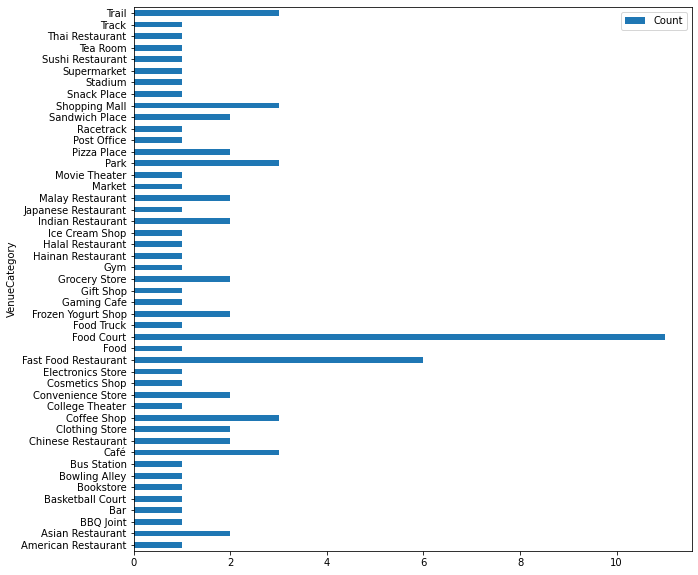

In [41]:
vens = dis_ideal.groupby('VenueCategory').count()['District'].to_frame()
vens.columns  =['Count']
vens.plot(kind = 'barh', figsize = (10, 10))

<b> Clearly, there is a lack of hotels in this district, even though there are various different restaurants available and other attractions like Shopping Mall or Racing Track. 
Thus, it is a great place open a new hotel.</b>

<img src = './images/3.png' width = 400 height = 400>

The closest registered hotel is pretty far away, in another district